In [1]:
from neuron import h, gui
from neuron.units import ms, mV
import numpy as np
from os import name
import matplotlib.pyplot as plt

In [2]:
h.load_file("stdrun.hoc")

1.0

In [3]:
class Cell:
    def __init__(self, gid, x, y, z):
        self._gid = gid
        self._setup_morphology()
        self.all = self.soma.wholetree()
        self._setup_biophysics()
        self.x = self.y = self.z = 0  # <-- NEW
        h.define_shape()
        #self._rotate_z(theta)  # <-- NEW
        self._set_position(x, y, z)  # <-- NEW


    def __repr__(self):
        return "{}[{}]".format(self.name, self._gid)


    def _set_position(self, x, y, z):
        for sec in self.all:
            for i in range(sec.n3d()):
                sec.pt3dchange(
                    i,
                    x - self.x + sec.x3d(i),
                    y - self.y + sec.y3d(i),
                    z - self.z + sec.z3d(i),
                    sec.diam3d(i),
                )
        self.x, self.y, self.z = x, y, z


In [4]:
class PointNeuron(Cell):
    name = "BallAndStick"

    def _setup_morphology(self):
        self.soma = h.Section(name="soma", cell=self)
        self.syn_E = h.Exp2Syn(self.soma(0.5)) # wczesniej h.ExpSyn(self.soma(0.5))
        self.syn_E.tau1 = 0.5 * ms #
        self.syn_E.tau2 = 2 * ms #
        self.syn_E.e = 0* mV #
        #self.dend = h.Section(name="dend", cell=self)
        #self.dend.connect(self.soma)
        self.soma.L = self.soma.diam = 12.6157
        #self.dend.L = 200
        #self.dend.diam = 1
        self.virtual_axon = None

    def _setup_biophysics(self):
        for sec in self.all:
            sec.Ra = 100  # Axial resistance in Ohm * cm
            sec.cm = 1  # Membrane capacitance in micro Farads / cm^2
        self.soma.insert("hh")
        for seg in self.soma:
            seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
            seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
            seg.hh.gl = 0.0003  # Leak conductance in S/cm2
            seg.hh.el = -54.3  # Reversal potential in mV
        # Insert passive current in the dendrite
        #self.dend.insert("pas")
        #for seg in self.dend:
        #    seg.pas.g = 0.001  # Passive conductance in S/cm2
        #    seg.pas.e = -65  # Leak reversal potential mV

In [5]:
def create_n_Neurons(netdim_x, netdim_y,netdim_z,x0,y0,z0):
    Dx = 50
    Dy = 50
    Dz = 50

    cells = []
    counter = 0
    for i in range(netdim_x):
        for j in range(netdim_y):
            for k in range(netdim_z):
                cells.append(PointNeuron(counter,x0+i*Dx,y0+j*Dy,z0+k*Dz))
                counter += 1
    return cells

my_cells_E = create_n_Neurons(8,8,1,0,0,0)
my_cells_I = create_n_Neurons(4,4,1,90,90,-90)


In [7]:
ncstims = []
stims = []
for i in my_cells_E:
    stim = h.NetStim()
    stim.number = 100
    stim.interval = 5
    
    stim.start = 0
    stim.noise = 1
    syn_ = h.ExpSyn(i.soma(0.5))
    syn_.tau = 2 * ms
    syn_.e = 0 * mV
    ncstim = h.NetCon(stim,syn_,0,0,0.3)
    stims.append(stim)
    ncstims.append(ncstim)

In [8]:
netcons_E = [] #network connections E --> E

netcons_E_I = [] #network connections E --> I
netcons_I_E = [] #network connections I --> E
netcons_I = []

connections = []
connection_prob_E = 0.8  # 0.8
connection_prob_EI = 0.7 # 0.7
connection_prob_IE = 0.7 # 0.7
connection_prob_I = 0.7 # 0.7


In [9]:
# connections between E <---> E cells
for source in my_cells_E:
    for target in my_cells_E:
        prob = np.random.uniform()
        if(prob <= connection_prob_E) and (source != target):
            dist = np.linalg.norm([source.x - target.x, source.y - target.y, source.z - target.z])# write function to calculate distance from source to target
            nc_E = h.NetCon(source.soma(0.5)._ref_v, target.syn_E, sec = source.soma) # None is for meanwhile   
            nc_E.weight[0] = 0.005 # 0.005
            nc_E.delay = 0.0005 * dist # 0.0005
            netcons_E.append(nc_E)

            if source.virtual_axon == None: 
                source.virtual_axon = h.Section(name='soma')
            
            source.virtual_axon.pt3dadd(source.x, source.y, source.z,1)
            source.virtual_axon.pt3dadd(target.x, target.y, target.z,1)

# connections I ---> E cells
for source in my_cells_I:
    for target in my_cells_E:
        prob = np.random.uniform()
        if(prob <= connection_prob_IE) and (source != target):
            dist = np.linalg.norm([source.x - target.x, source.y - target.y, source.z - target.z])# write function to calculate distance from source to target
            nc_IE = h.NetCon(source.soma(0.5)._ref_v, target.syn_E, sec = source.soma) # None is for meanwhile   
            nc_IE.weight[0] = 0.5 # 0.5
            nc_IE.delay = 0.00005 * dist # 0.00005
            netcons_I_E.append(nc_IE)

            if source.virtual_axon == None: 
                source.virtual_axon = h.Section(name='soma')
            
            source.virtual_axon.pt3dadd(source.x, source.y, source.z,1)
            source.virtual_axon.pt3dadd(target.x, target.y, target.z,1)
# connections E ---> I cells
for source in my_cells_E:
    for target in my_cells_I:
        prob = np.random.uniform()
        if(prob <= connection_prob_EI) and (source != target):
            dist = np.linalg.norm([source.x - target.x, source.y - target.y, source.z - target.z])# write function to calculate distance from source to target
            nc_EI = h.NetCon(source.soma(0.5)._ref_v, target.syn_E, sec = source.soma) # None is for meanwhile   
            nc_EI.weight[0] = 0.05 # 0.05
            nc_EI.delay = 0.00005 * dist # 0.00005
            netcons_E_I.append(nc_EI)

            if source.virtual_axon == None: 
                source.virtual_axon = h.Section(name='soma')
            
            source.virtual_axon.pt3dadd(source.x, source.y, source.z,1)
            source.virtual_axon.pt3dadd(target.x, target.y, target.z,1)

# Polaczenia I ---> I
for source in my_cells_I:
    for target in my_cells_I:
        prob = np.random.uniform()
        if(prob <= connection_prob_I) and (source != target):
            dist = np.linalg.norm([source.x - target.x, source.y - target.y, source.z - target.z])# write function to calculate distance from source to target
            nc_I = h.NetCon(source.soma(0.5)._ref_v, target.syn_E, sec = source.soma) # None is for meanwhile   
            nc_I.weight[0] = 0.5 # 0.5
            nc_I.delay = 0.00005 * dist # 0.00005
            netcons_I.append(nc_I)

            if source.virtual_axon == None: 
                source.virtual_axon = h.Section(name='soma')
            
            source.virtual_axon.pt3dadd(source.x, source.y, source.z,1)
            source.virtual_axon.pt3dadd(target.x, target.y, target.z,1)

In [10]:
# setup for rasterplot

# for upper layer
spike_times_vec_E = h.Vector()
id_vec_E = h.Vector()

# For down layer
spike_times_vec_I = h.Vector()
id_vec_I = h.Vector()

# For stimulus spike recording
spike_times_Stim = h.Vector()
id_vec_Stim = h.Vector()

for i,cell in enumerate(my_cells_E):
        nc_E = h.NetCon(cell.soma(0.5)._ref_v, None, sec = cell.soma)
        nc_E.record(spike_times_vec_E, id_vec_E, i)
del nc_E

for i,cell in enumerate(my_cells_I):
        nc_I = h.NetCon(cell.soma(0.5)._ref_v, None, sec = cell.soma)
        nc_I.record(spike_times_vec_I, id_vec_I, i+64)
del nc_I

for i,cell in enumerate(stims):
        nc_stim = h.NetCon(cell, None)
        nc_stim.record(spike_times_Stim, id_vec_Stim, i-64)
del nc_stim

t = h.Vector().record(h._ref_t)

In [11]:
recording_cell_E = my_cells_E[31]

soma_v_E = h.Vector().record(recording_cell_E.soma(0.5)._ref_v)

recording_cell_I = my_cells_I[7]

soma_v_I = h.Vector().record(recording_cell_I.soma(0.5)._ref_v)

In [12]:
# Zapis EEG
all_E_spikes = []
for cell in my_cells_E:
    soma_v = h.Vector().record(cell.soma(0.5)._ref_v)
    all_E_spikes.append(soma_v)


all_I_spikes = []
for cell in my_cells_I:
    soma_v = h.Vector().record(cell.soma(0.5)._ref_v)
    all_I_spikes.append(soma_v)


In [13]:
# here i chacke the values
h.finitialize(-65 * mV)
h.continuerun(200 * ms)

0.0

In [14]:
Converted_E_spikes = np.array(all_E_spikes)
Converted_I_spikes = np.array(all_I_spikes)

# Połączenie macierzy wzdłuż pionowej osi
combined_EI_Spikes = np.vstack((Converted_E_spikes, Converted_I_spikes))

EEG = np.mean(combined_EI_Spikes, axis=0) 
const = np.average(EEG)
EEG = EEG - const


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


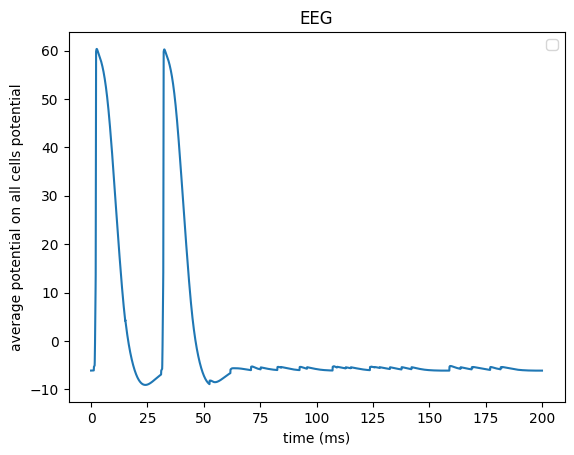

In [15]:
# Test EEG
plt.figure()
plt.plot(t, EEG)
plt.xlabel('time (ms)')
plt.ylabel('average potential on all cells potential')
plt.title('EEG')
plt.legend()
plt.show()

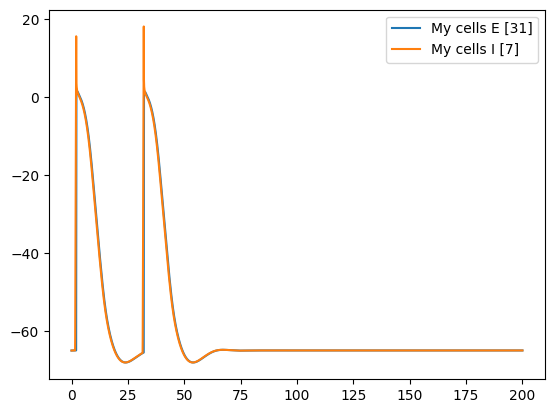

In [16]:
# Zachowanie pojedynczych komórek E oraz I
plt.figure()
plt.plot(t, soma_v_E, label="My cells E [31]")
plt.plot(t, soma_v_I, label="My cells I [7]")
plt.legend()
plt.show()

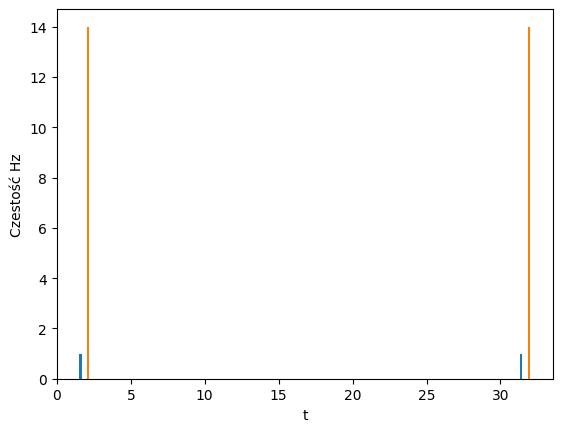

In [19]:
# Chwilowa częstość odpalania
plt.figure()
plt.hist(spike_times_vec_E, bins = 200)
plt.hist(spike_times_vec_I, bins = 200)
plt.xlabel('t')
plt.ylabel('Czestość Hz')
plt.show()


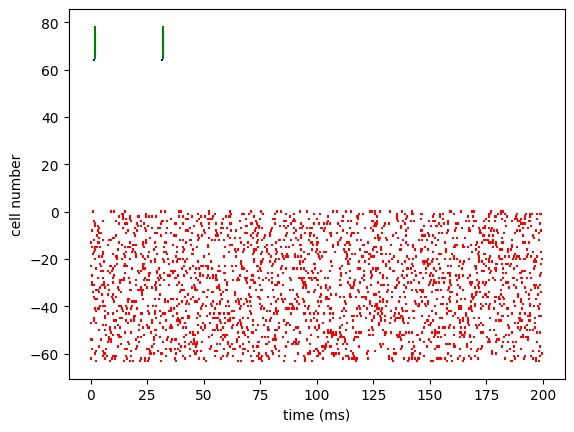

In [18]:
# Raster Plot

plt.figure()

for t, id in zip(spike_times_vec_E, id_vec_E):
    plt.vlines(t,id+0.5,id+1.5, colors='blue')

for t, id in zip(spike_times_vec_I, id_vec_I):
    plt.vlines(t,id+0.5,id+1.5, colors='green')

for t, id in zip(spike_times_Stim, id_vec_Stim):
    plt.vlines(t,id+0.5,id+1.5,colors='red')


plt.xlabel("time (ms)")
plt.ylabel('cell number')
plt.show()